In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape data from a single page
def scrape_page(page_number):
    url = f"https://www.chowari.jp/catcharea/?area=13&fish=597&page={page_number}"  # Replace with the actual URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    data = []
    
    # Find all catch items
    catch_items = soup.find_all('li', class_='catch_item')
    
    for item in catch_items:
        ship_name = item.find('h2').text
        location = item.find('div', class_='catch_item_location').text
        date_info = item.find('div', class_='catch_item_date').text
        fish_info = item.find('table', class_='catch_item_fish').find_all('td')
        fish_size = fish_info[0].text
        fish_count = fish_info[1].text
        
        # Extracting tide information
        tide_info = item.find('div', class_='catch_item_tidegraph').find('a')['href']
        
        # Extracting weather information
        weather_info = item.find('div', class_='catch_item_weather')
        weather_data = {
            'Sunrise': weather_info.find('li', class_='sunrise').find_all('p')[1].text,
            'Sunset': weather_info.find('li', class_='sunrise').find_all('p')[3].text,
            'Moonrise': weather_info.find('li', class_='moonrise').find_all('p')[1].text,
            'Moonset': weather_info.find('li', class_='moonrise').find_all('p')[3].text,
            'Weather': weather_info.find('li', class_='weather').find_all('p')[1].text,
            'Temperature': weather_info.find('li', class_='temperature').find_all('span')[0].text + '/' + weather_info.find('li', class_='temperature').find_all('span')[1].text,
            'Pressure': weather_info.find('li', class_='pressure').find_all('p')[1].text,
            'Wind': weather_info.find('li', class_='wind').find_all('p')[1].text,
            'Wave': weather_info.find('li', class_='wave').find_all('p')[1].text,
            'Water Temperature': weather_info.find('li', class_='water_temperature').find_all('p')[1].text,
            'Tide': weather_info.find('li', class_='tide').find_all('p')[1].text,
            'Moon Age': weather_info.find('li', class_='moon').find_all('p')[1].text,
            'BI': weather_info.find('li', class_='bi').find_all('p')[1].text
        }
        
        data.append({
            'Ship Name': ship_name,
            'Location': location,
            'Date Info': date_info,
            'Fish Size': fish_size,
            'Fish Count': fish_count,
            'Tide Info': tide_info,
            **weather_data
        })
    
    return data

# Function to scrape multiple pages
def scrape_multiple_pages(start_page, end_page):
    all_data = []
    
    for page in range(start_page, end_page + 1):
        page_data = scrape_page(page)
        all_data.extend(page_data)
    
    return all_data

# Scrape data from page 1 to 5 (example)
data = scrape_multiple_pages(1, 10)

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('fishing_data.csv', index=False)

print("Data scraping complete. Data saved to fishing_data.csv")


Data scraping complete. Data saved to fishing_data.csv


In [2]:
import pandas as pd
import numpy as np

# 欠損値や不正なデータを含む行を削除する関数
def clean_data(df):
    # 釣行日、曜日、潮を分割
    df['Fishing Date'] = df['Date Info'].str.extract(r'(\d{4}年\d{1,2}月\d{1,2}日)')
    df['Day of Week'] = df['Date Info'].str.extract(r'（(.+?)）')
    df['Tide Type'] = df['Date Info'].str.extract(r'）(.+)$')

    # 魚のサイズを分割
    df[['Fish Size Min', 'Fish Size Max']] = df['Fish Size'].str.extract(r'(\d+)～(\d+)').astype(float)

    # 釣れた数を分割
    df[['Fish Count Min', 'Fish Count Max']] = df['Fish Count'].str.extract(r'(\d+)～(\d+)').astype(float)

    # 気温を分割
    df[['Temperature Max', 'Temperature Min']] = df['Temperature'].str.extract(r'(\d+)℃/(\d+)℃').astype(float)

    # 気圧を数値化
    df['Pressure'] = df['Pressure'].str.replace('hPa', '').astype(float)

    # 風速を数値化
    df['Wind Speed'] = df['Wind'].str.extract(r'(\d+\.\d+)m/s').astype(float)

    # 波の高さを数値化
    df['Wave Height'] = df['Wave'].str.extract(r'(\d+\.\d+)m/s').astype(float)

    # 水温を数値化
    df['Water Temperature'] = df['Water Temperature'].str.replace('℃', '').astype(float)

    # 月齢を数値化
    df['Moon Age'] = df['Moon Age'].astype(float)

    # BIを数値化
    df['BI'] = df['BI'].astype(float)

    # 不要な列を削除
    df.drop(columns=['Date Info', 'Fish Size', 'Fish Count', 'Temperature', 'Wind', 'Wave'], inplace=True)

    # 欠損値を含む行を削除
    df.dropna(inplace=True)

    return df

# データをクリーンアップ
df_cleaned = clean_data(df)

# 結果を表示
print(df_cleaned)

    Ship Name     Location                                 Tide Info Sunrise  \
0          丸裕  東京都 港区 京浜運河  https://tide.chowari.jp/13/131032/21349/   04:25   
1      えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:24   
2      えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:24   
3      えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:24   
4      えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:24   
..        ...          ...                                       ...     ...   
139    えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:32   
140    えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:29   
141        丸裕  東京都 港区 京浜運河  https://tide.chowari.jp/13/131032/21349/   04:29   
142    えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:26   
143    えさ政釣船店   東京都 大田区 羽田  https://tide.chowari.jp/13/131113/23427/   04:25   

    Sunset Moonrise Moonset  Weather  P

In [3]:
df_cleaned

,Ship Name,Location,Tide Info,Sunrise,Sunset,Moonrise,Moonset,Weather,Pressure,Water Temperature,...,Day of Week,Tide Type,Fish Size Min,Fish Size Max,Fish Count Min,Fish Count Max,Temperature Max,Temperature Min,Wind Speed,Wave Height
0,丸裕,東京都 港区 京浜運河,https://tide.chowari.jp/13/131032/21349/,04:25,18:59,13:23,00:31,晴れ時々曇り,1003.8,23.4,...,日,若潮,20.0,35.0,3.0,8.0,29.0,20.0,0.2,0.2
1,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:24,18:58,12:27,00:08,晴れ後一時雨,1010.2,22.4,...,土,長潮,22.0,34.0,0.0,8.0,30.0,21.0,1.9,0.2
2,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:24,18:58,11:31,,晴れ,1008.4,22.2,...,金,小潮,22.0,35.0,0.0,7.0,31.0,20.0,0.6,0.3
3,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:24,18:58,10:34,23:46,曇り時々晴れ,1006.5,21.9,...,木,小潮,22.0,34.0,0.0,5.0,27.0,20.0,0.4,0.2
4,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:24,18:57,08:34,22:55,晴れ時々曇り,1011.0,21.5,...,火,中潮,22.0,36.0,1.0,6.0,29.0,18.0,1.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:32,19:00,22:40,09:40,曇り,1007.9,25.4,...,土,中潮,18.0,33.0,2.0,43.0,31.0,24.0,6.2,0.7
140,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:29,19:01,18:06,02:36,晴れ後時々曇り,1008.4,23.9,...,日,大潮,18.0,37.0,0.0,10.0,32.0,24.0,1.0,0.4
141,丸裕,東京都 港区 京浜運河,https://tide.chowari.jp/13/131032/21349/,04:29,19:01,18:06,02:36,晴れ時々曇り,1008.3,24.8,...,日,大潮,17.0,40.0,0.0,11.0,33.0,23.0,0.8,0.2
142,えさ政釣船店,東京都 大田区 羽田,https://tide.chowari.jp/13/131113/23427/,04:26,19:01,09:37,23:05,曇り時々晴れ,1013.0,22.6,...,土,小潮,17.0,34.0,0.0,12.0,29.0,22.0,0.9,0.3


In [4]:
df_cleaned.iloc[0]

Ship Name                                                  丸裕
Location                                          東京都 港区 京浜運河
Tide Info            https://tide.chowari.jp/13/131032/21349/
Sunrise                                                 04:25
Sunset                                                  18:59
Moonrise                                                13:23
Moonset                                                 00:31
Weather                                                晴れ時々曇り
Pressure                                               1003.8
Water Temperature                                        23.4
Tide                                                       若潮
Moon Age                                                  9.6
BI                                                        7.5
Fishing Date                                       2024年6月16日
Day of Week                                                 日
Tide Type                                                  若潮
Fish Siz

#############Fish Count Max#################
Root Mean Squared Error: 8.180724868904067
              Feature  Coefficient
0             Sunrise     1.635199
1              Sunset     1.170321
2            Moonrise     0.005120
3             Moonset    -0.008072
4            Pressure     0.386789
5   Water Temperature    -0.537473
6            Moon Age     0.455246
7                  BI    -3.383604
8     Temperature Max     0.429481
9     Temperature Min     0.677545
10         Wind Speed     1.566718
11        Wave Height     4.190586
12            Tide_中潮     1.935397
13            Tide_大潮     0.089596
14            Tide_小潮    -5.966653
15            Tide_若潮     0.616942
16            Tide_長潮     3.324717
17         Weather_晴れ     2.442791
18     Weather_晴れ後一時雨   -11.059226
19    Weather_晴れ後時々曇り    -0.717746
20     Weather_晴れ時々曇り    -0.435232
21         Weather_曇り    -2.567346
22    Weather_曇りのち一時雨     9.632319
23   Weather_曇りのち時々晴れ    -4.548044
24      Weather_曇り一時雨     5.281563
25

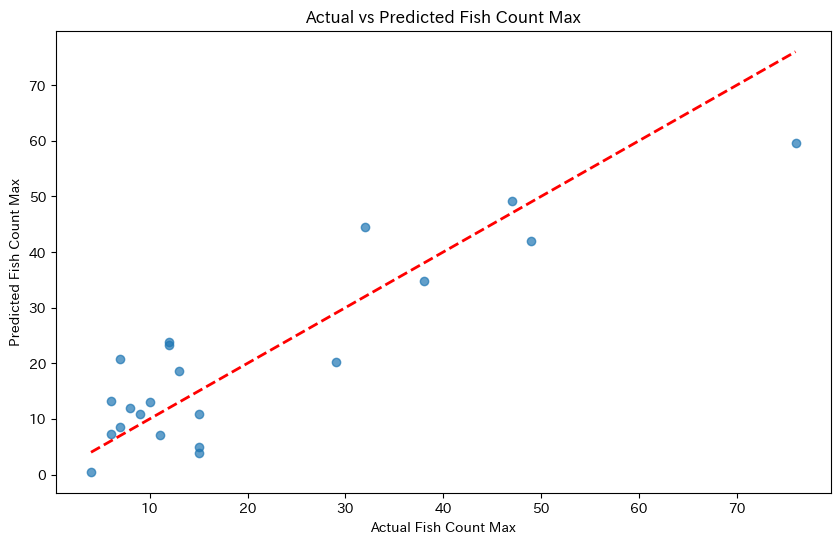

Root Mean Squared Error: 11.209352600140907
              Feature  Importance
5   Water Temperature    0.312278
9     Temperature Min    0.195919
7                  BI    0.058724
31      Day of Week_木    0.055249
8     Temperature Max    0.048109
10         Wind Speed    0.046913
3             Moonset    0.044274
42            Month_8    0.035021
6            Moon Age    0.034701
4            Pressure    0.033481
2            Moonrise    0.025404
11        Wave Height    0.018705
1              Sunset    0.017774
0             Sunrise    0.012095
29      Day of Week_日    0.010176
28      Day of Week_土    0.008547
34      Day of Week_金    0.007658
18     Weather_晴れ後一時雨    0.006784
39            Month_5    0.004803
12            Tide_中潮    0.003173
20     Weather_晴れ時々曇り    0.002876
25     Weather_曇り時々晴れ    0.002871
33      Day of Week_火    0.002478
24      Weather_曇り一時雨    0.002413
43            Month_9    0.001971
19    Weather_晴れ後時々曇り    0.001325
14            Tide_小潮    0.001117
17  

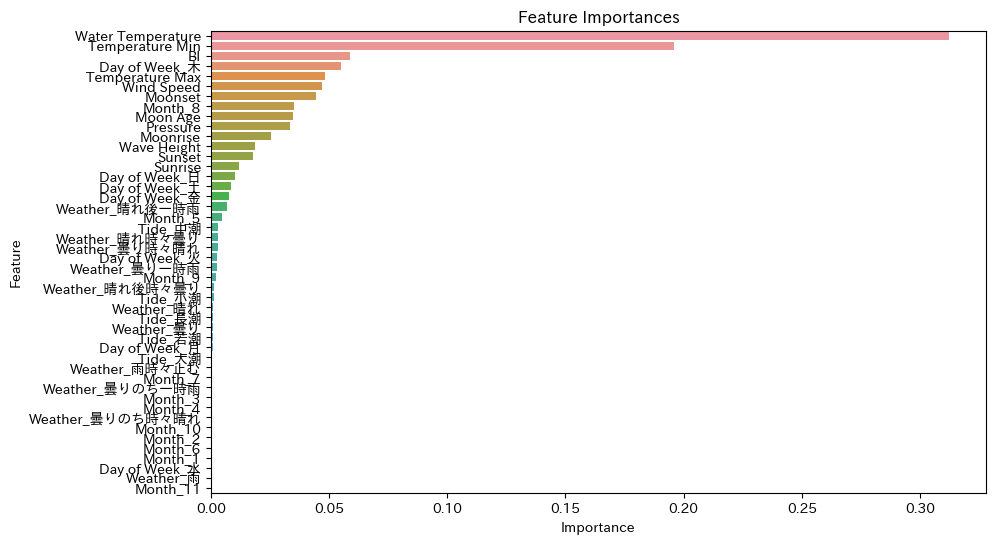

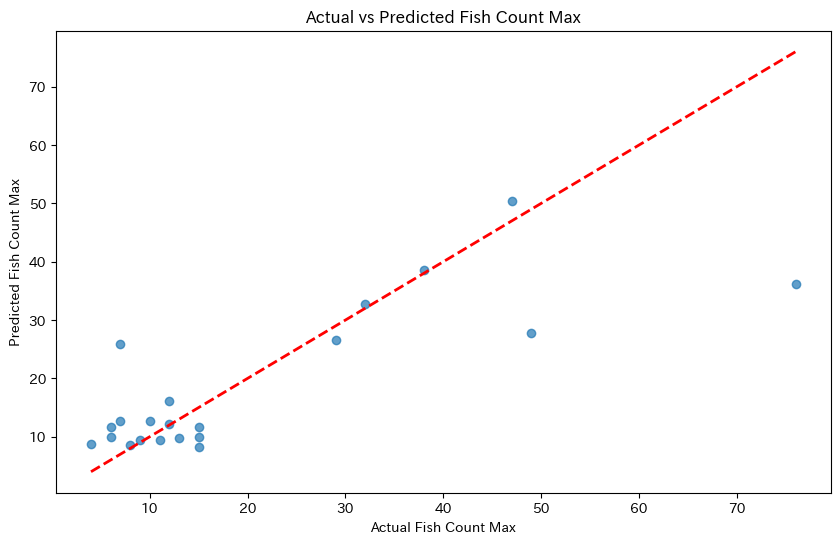

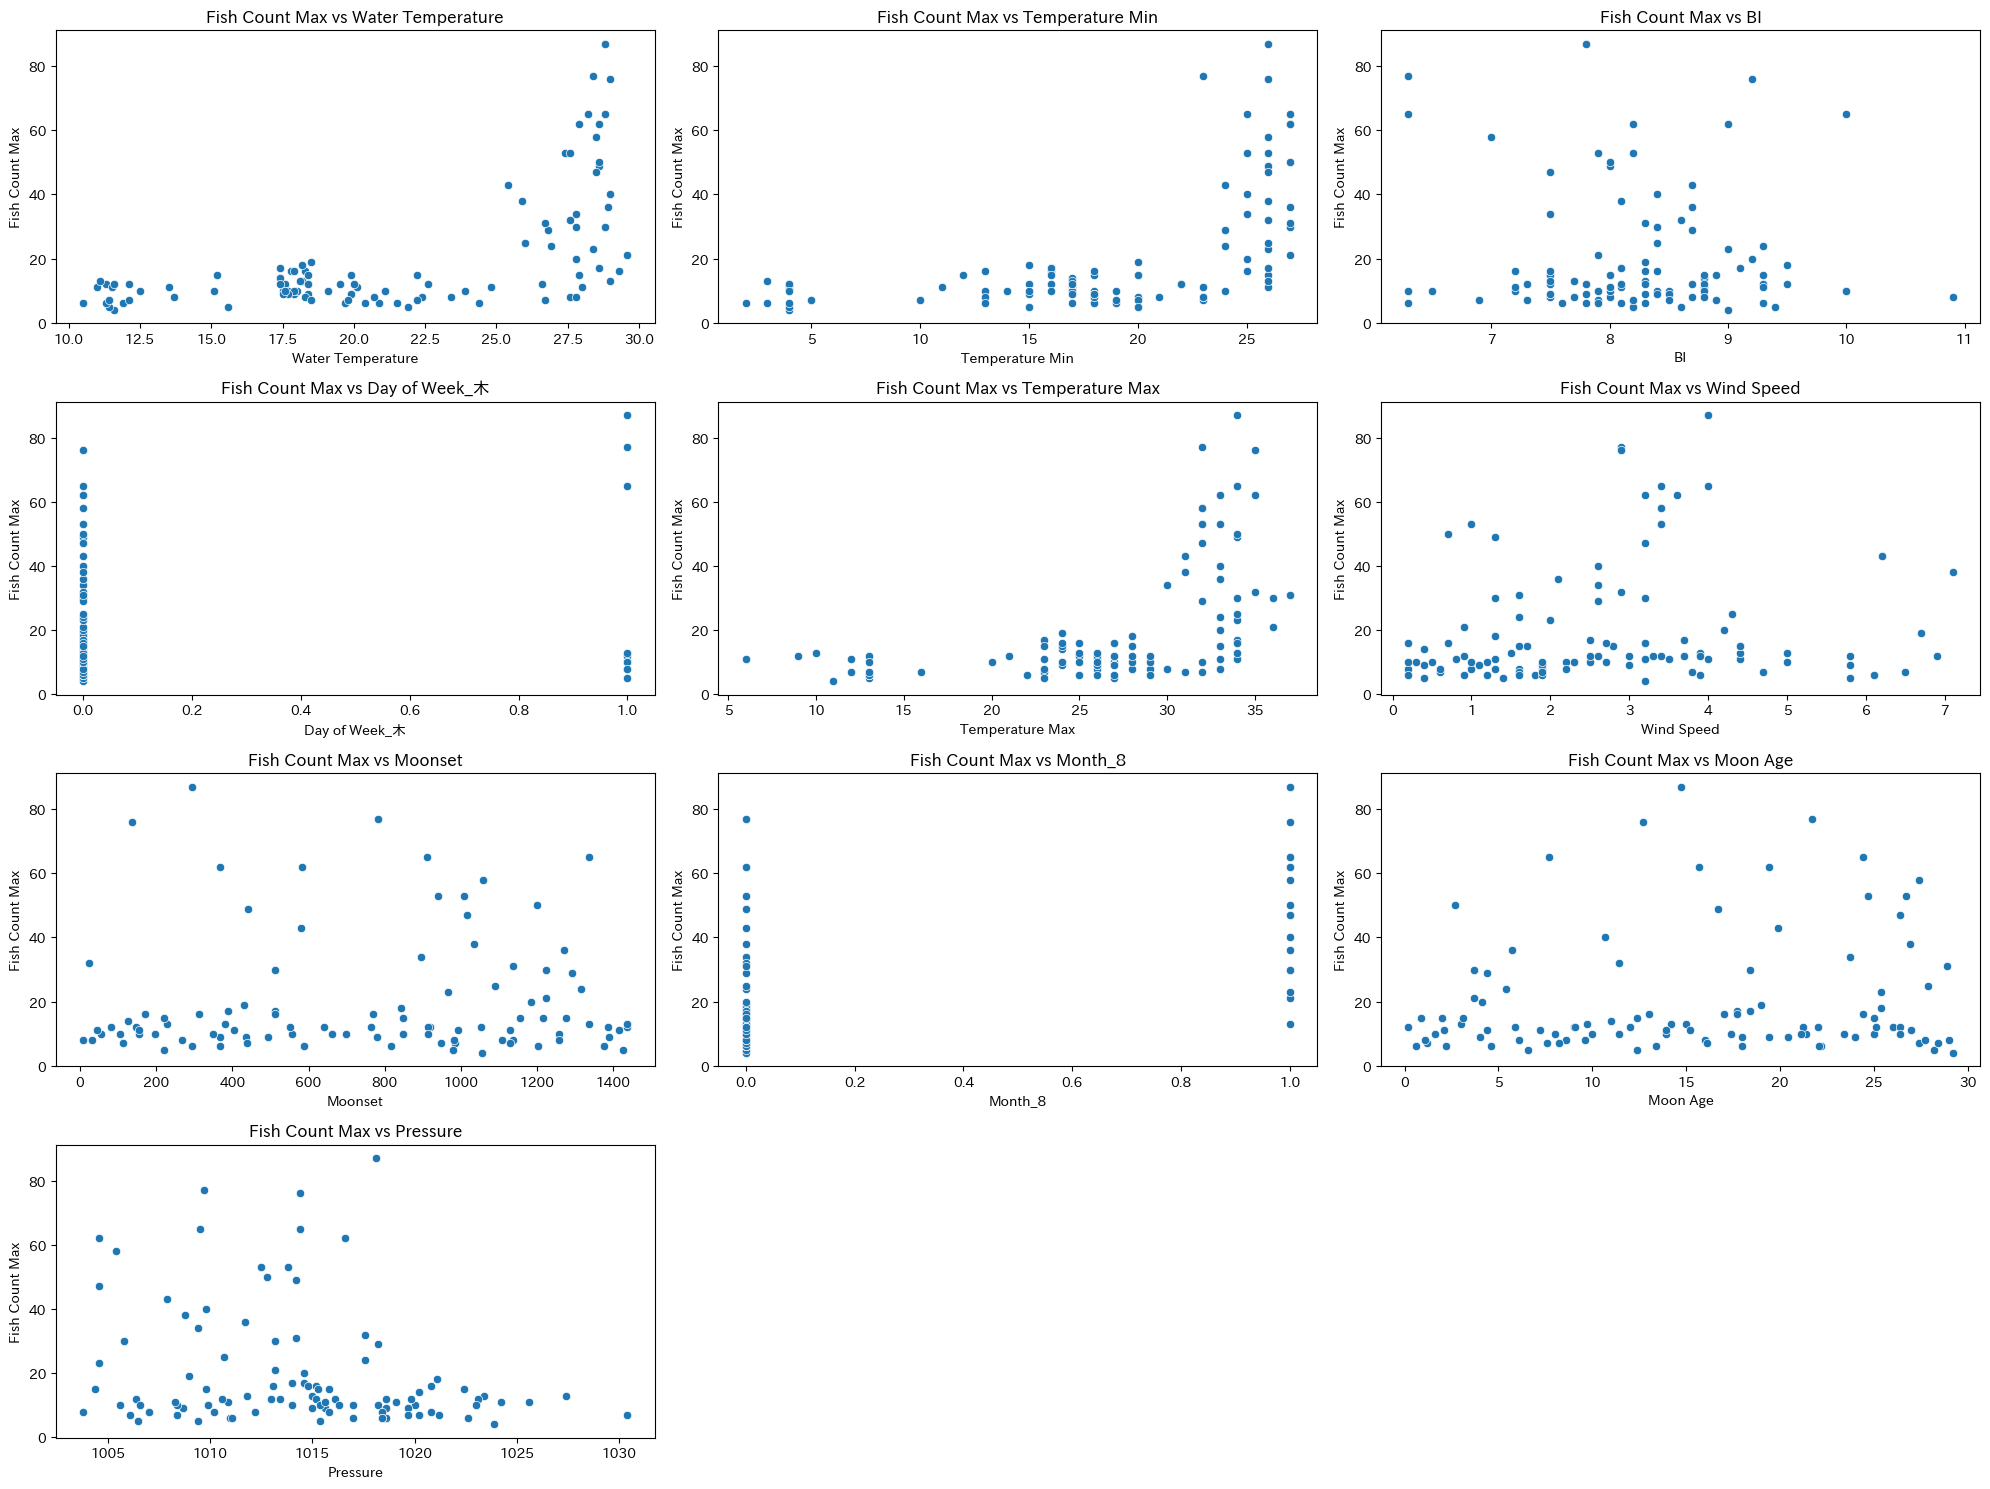

#############Fish Count Min#################
Root Mean Squared Error: 3.1441426043882936
              Feature  Coefficient
0             Sunrise     0.222819
1              Sunset    -0.009555
2            Moonrise     0.003090
3             Moonset    -0.001265
4            Pressure     0.242520
5   Water Temperature     0.058562
6            Moon Age     0.080882
7                  BI    -0.966647
8     Temperature Max    -0.398003
9     Temperature Min     0.424846
10         Wind Speed     0.527399
11        Wave Height    -2.683620
12            Tide_中潮    -1.067324
13            Tide_大潮     0.605214
14            Tide_小潮     0.180933
15            Tide_若潮     0.508988
16            Tide_長潮    -0.227812
17         Weather_晴れ     0.132467
18     Weather_晴れ後一時雨    -1.788059
19    Weather_晴れ後時々曇り    -0.875465
20     Weather_晴れ時々曇り    -0.809386
21         Weather_曇り    -3.798929
22    Weather_曇りのち一時雨     0.874351
23   Weather_曇りのち時々晴れ     0.608410
24      Weather_曇り一時雨    -0.307529
2

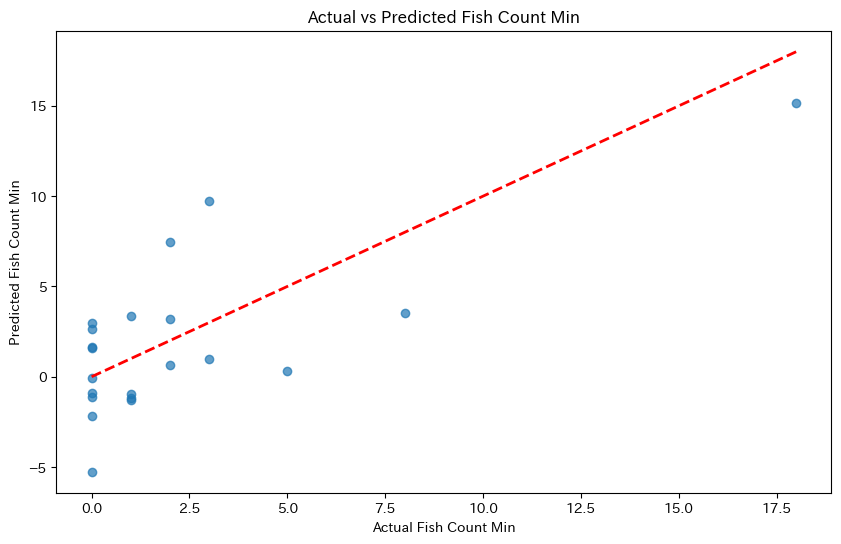

Root Mean Squared Error: 3.1010789213095618
              Feature  Importance
5   Water Temperature    0.378393
7                  BI    0.128151
11        Wave Height    0.073767
10         Wind Speed    0.040224
31      Day of Week_木    0.038867
4            Pressure    0.037868
42            Month_8    0.034185
3             Moonset    0.033646
9     Temperature Min    0.032879
2            Moonrise    0.030314
8     Temperature Max    0.029751
6            Moon Age    0.019103
1              Sunset    0.018856
27      Weather_雨時々止む    0.016737
0             Sunrise    0.016391
43            Month_9    0.009221
14            Tide_小潮    0.008238
12            Tide_中潮    0.007347
33      Day of Week_火    0.007285
29      Day of Week_日    0.006369
20     Weather_晴れ時々曇り    0.004914
24      Weather_曇り一時雨    0.004687
13            Tide_大潮    0.004450
28      Day of Week_土    0.003415
15            Tide_若潮    0.001877
16            Tide_長潮    0.001825
21         Weather_曇り    0.001819
18  

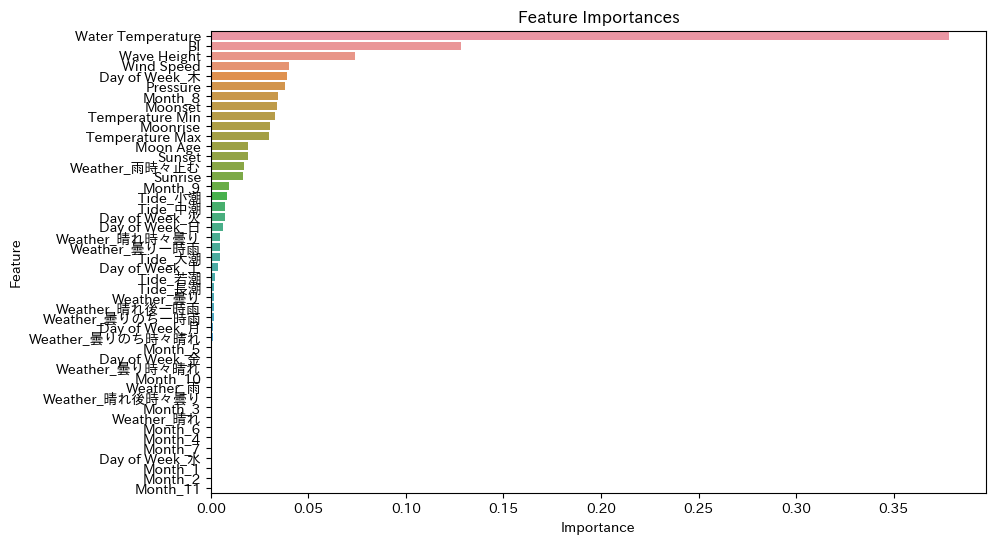

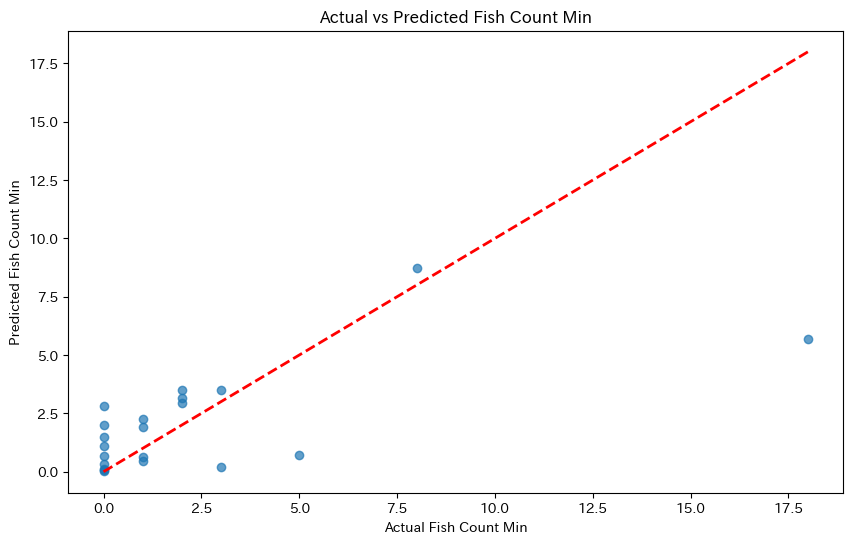

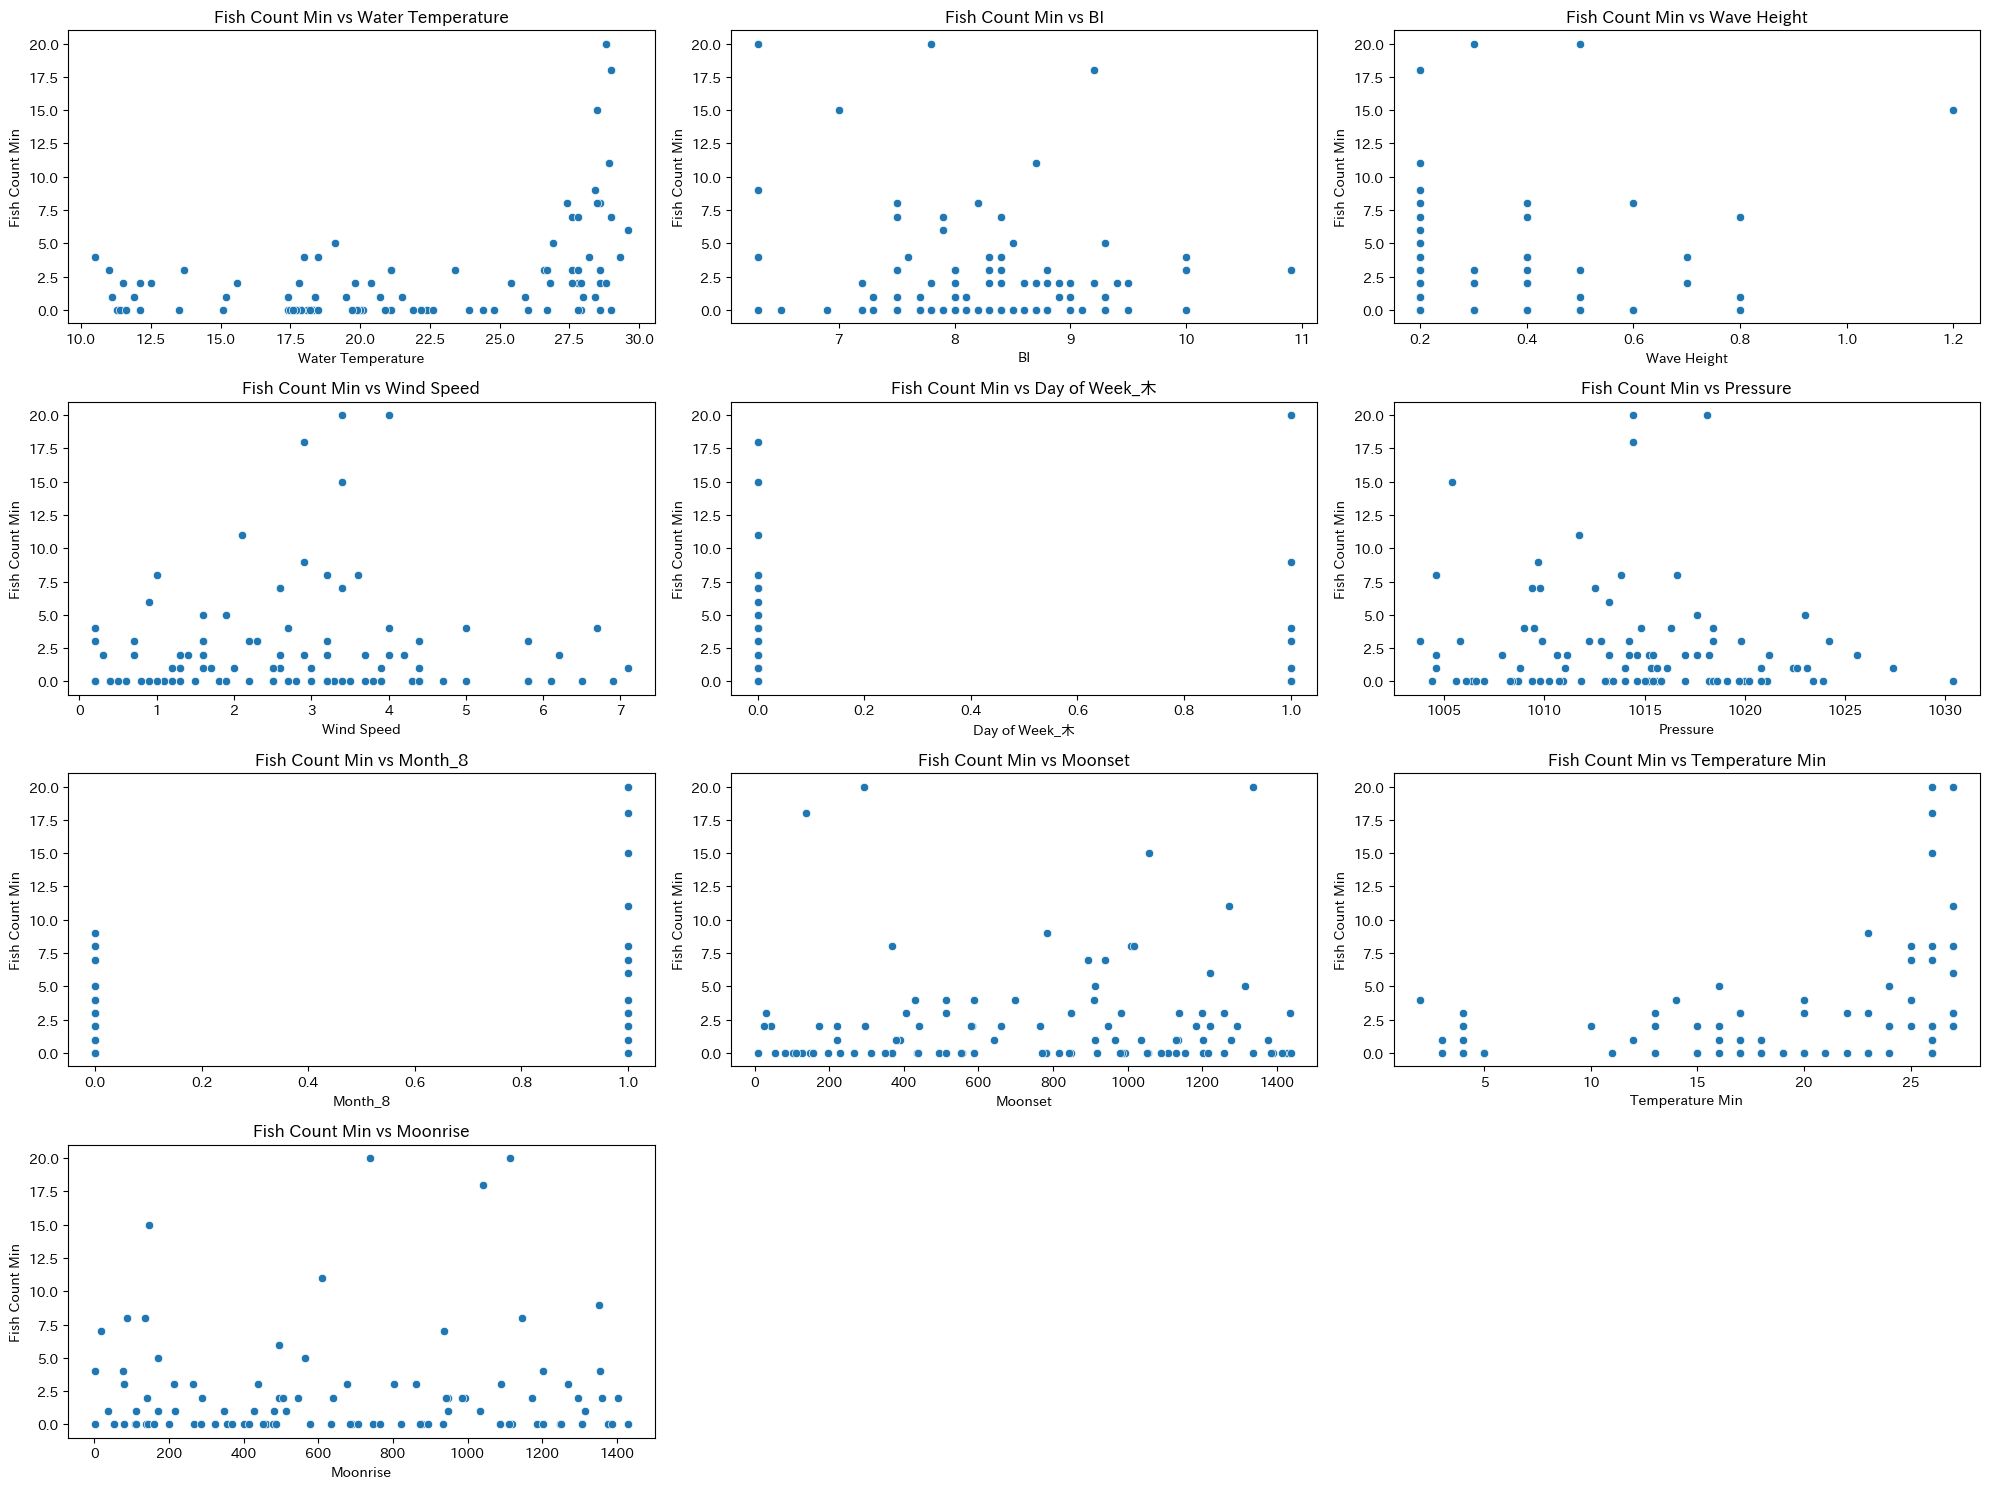

In [5]:
import pandas as pd
import numpy as np
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

df = df_cleaned.copy()

# Fishing Dateを標準的な日付形式に変換
def date_manipulate(x):
    x = x.str.strip()
    x = x.str.replace('年', '-')
    x = x.str.replace('月', '-')
    x = x.str.replace('日', '')
    x = pd.to_datetime(x, errors='coerce')
    return x

df['Fishing Date'] = date_manipulate(df['Fishing Date'])

# Fishing Dateからmonthを抽出
df['Month'] = df['Fishing Date'].dt.month

# 時間を分単位に変換する関数
def time_to_minutes(time_str):
    if pd.isna(time_str) or time_str == '':
        return np.nan
    h, m = map(int, time_str.split(':'))
    return h * 60 + m

# 時間に関係する列を分単位に変換
time_columns = ['Sunrise', 'Sunset', 'Moonrise', 'Moonset']
for col in time_columns:
    df[col] = df[col].apply(time_to_minutes)

# カテゴリ変数をワンホットエンコーディング
df_encoded = pd.get_dummies(df, columns=['Tide', 'Weather', 'Day of Week', 'Month'])

# 特徴量とターゲットの設定
features = [col for col in df_encoded.columns if col not in ['Fish Count Max', 'Fish Count Min','Fish Size Min','Fish Size Max','Ship Name', 'Location', 'Tide Info', 'Fishing Date', 'Tide Type', 'Fish Count Max']]
for target in ['Fish Count Max', 'Fish Count Min']:
    print(f"#############{target}#################")
    X = df_encoded[features]
    y = df_encoded[target]

    # NaN値を補完するためのSimpleImputerを作成
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # 訓練データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    ## 重回帰モデルの作成
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 予測
    y_pred = model.predict(X_test)
    
    # モデルの評価
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse}')

    # 回帰係数の表示
    coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
    print(coefficients)

    # 回帰式の表示
    intercept = model.intercept_
    print(f'Intercept: {intercept}')

    # 予測値と実際の値の散布図を描画
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()
    
    # RandomForestモデルの作成
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 予測
    y_pred = model.predict(X_test)

    # モデルの評価
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse}')

    # 特徴量の重要度を算出
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # 特徴量の重要度を表示
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)

    # 特徴量の重要度を可視化
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances')
    plt.show()
    
    # 予測値と実際の値の散布図を描画
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

    # 重要度の大きい特徴量上位10個に対して、targetとの散布図を描画
    top_features = importance_df['Feature'].head(10).tolist()
    fig, axes = plt.subplots(4, 3, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        sns.scatterplot(data=df_encoded, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f'{target} vs {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)

    # 不要なサブプロットを削除
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


C:\Users\wakazaki shogo\AppData\Local\Temp\ipykernel_30636\2552690627.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


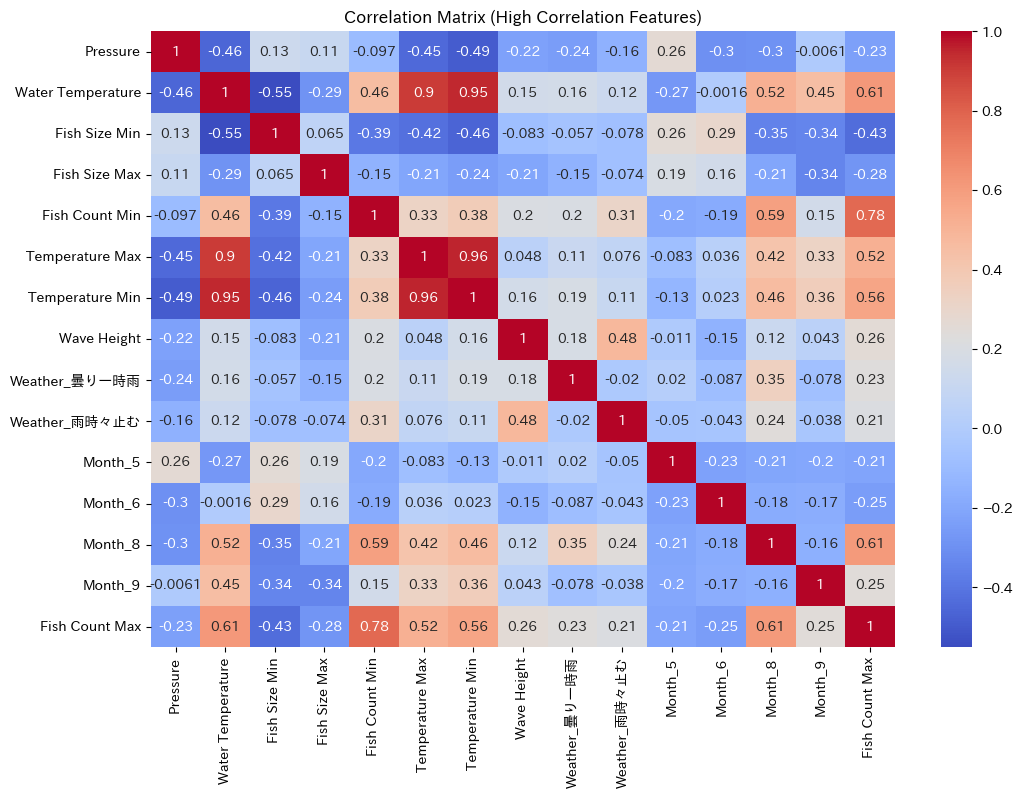

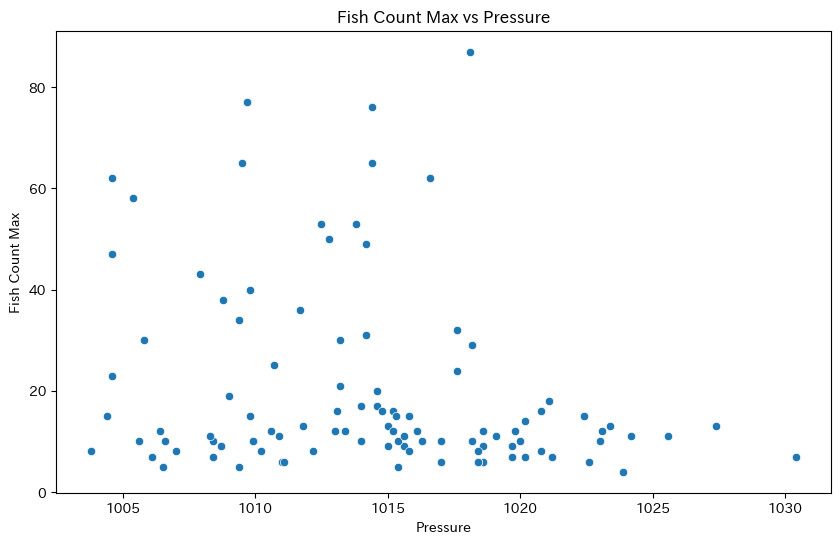

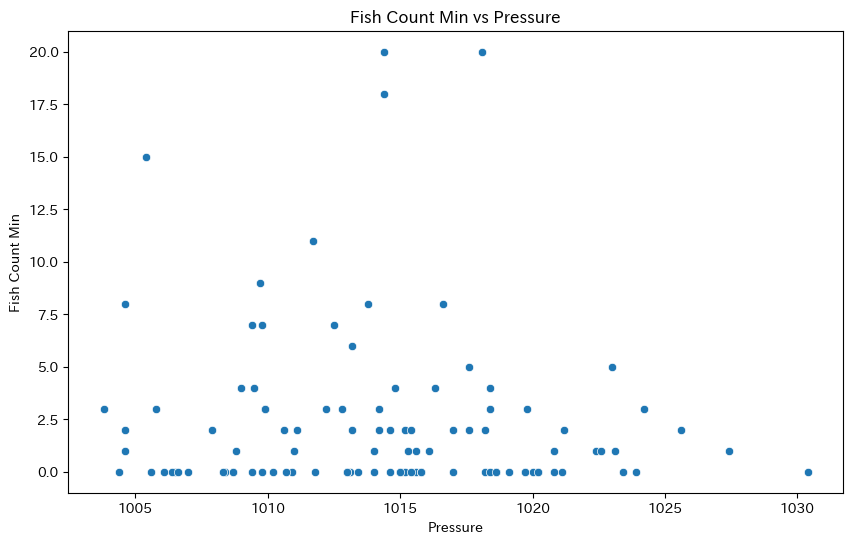

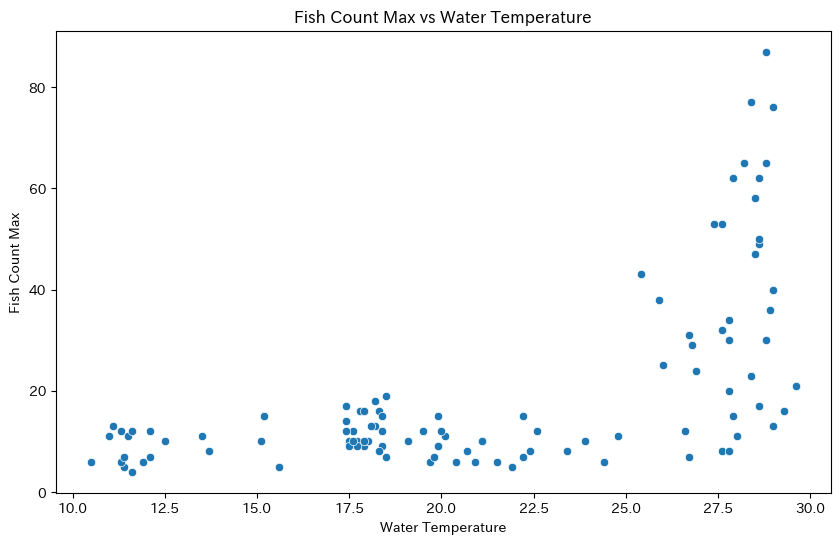

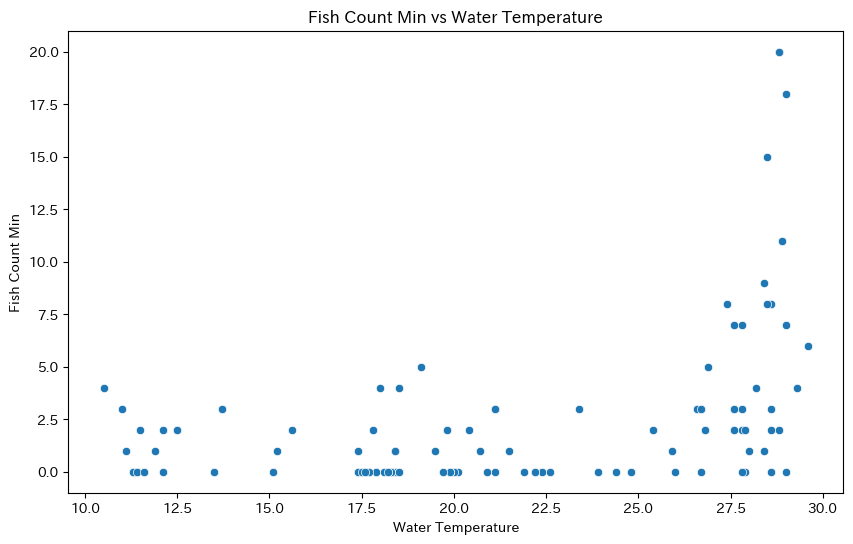

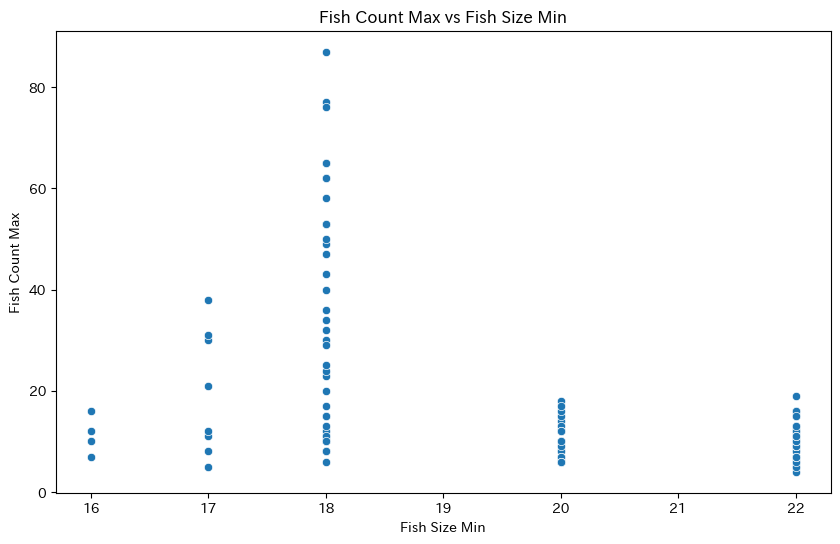

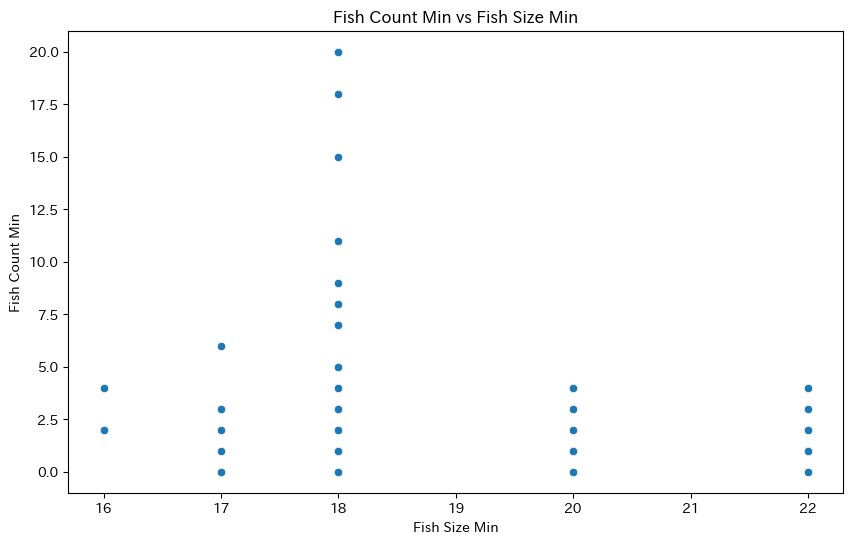

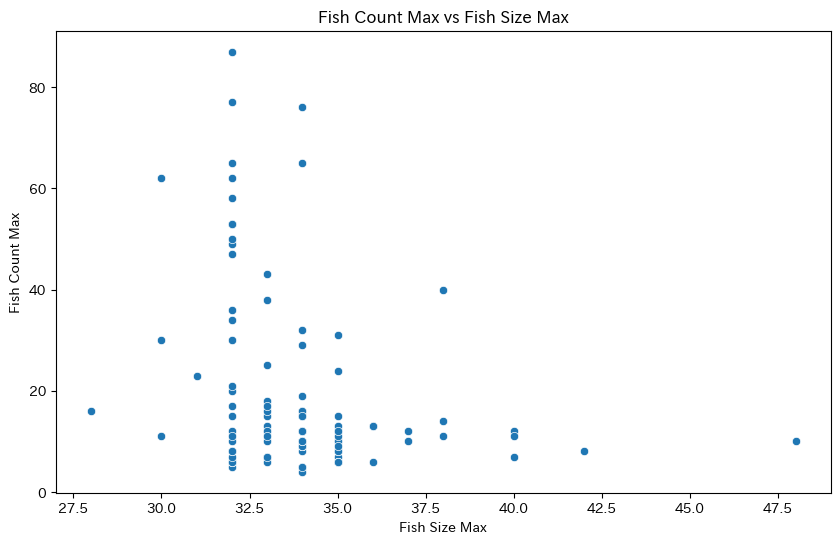

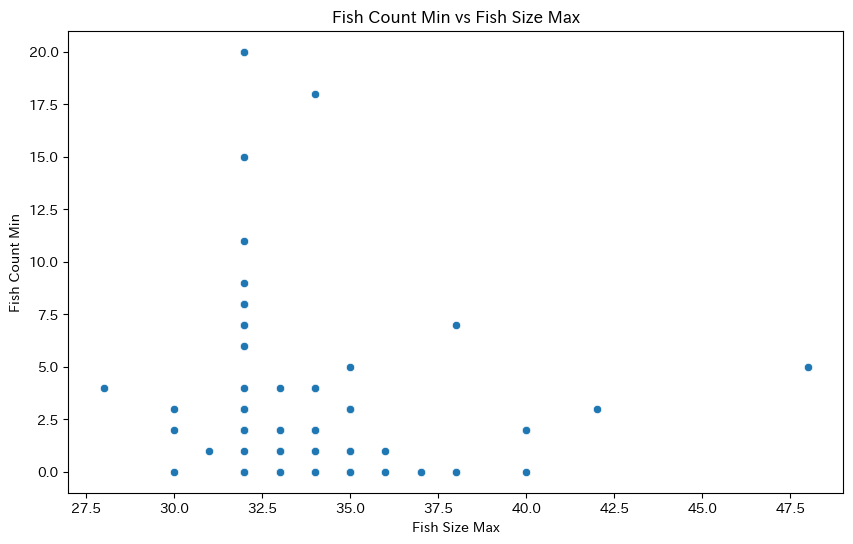

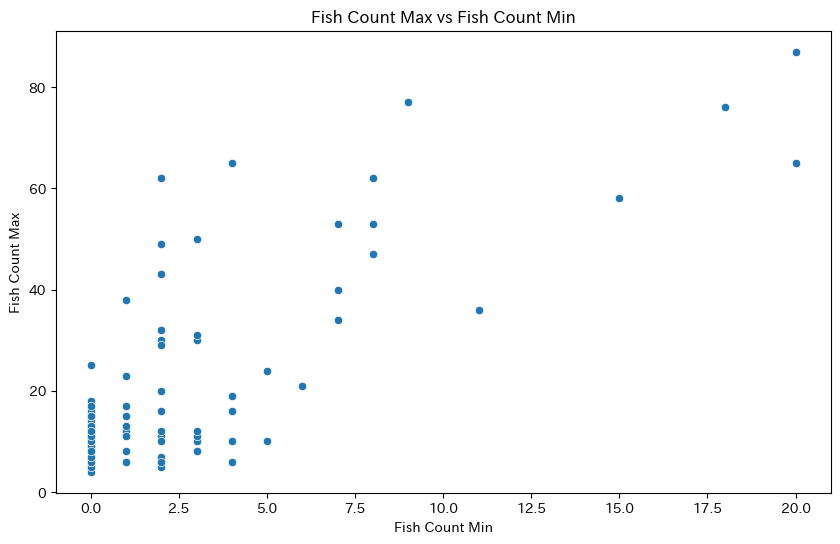

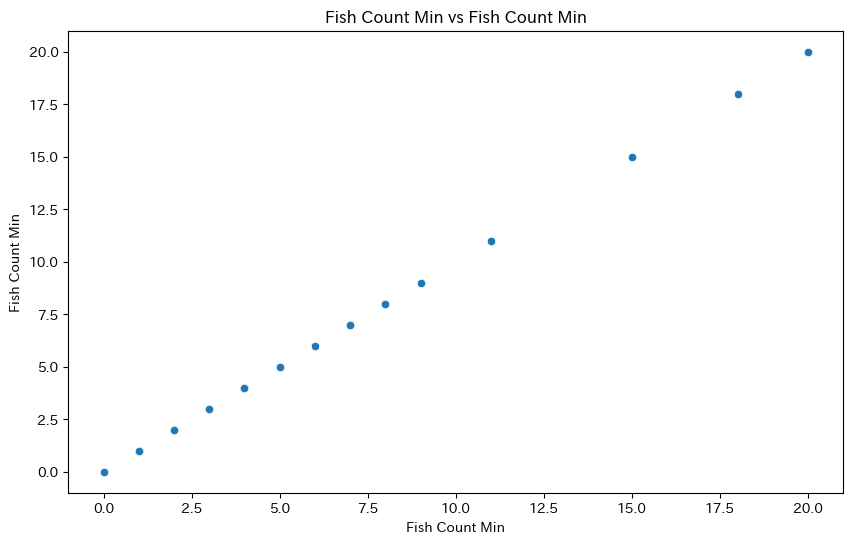

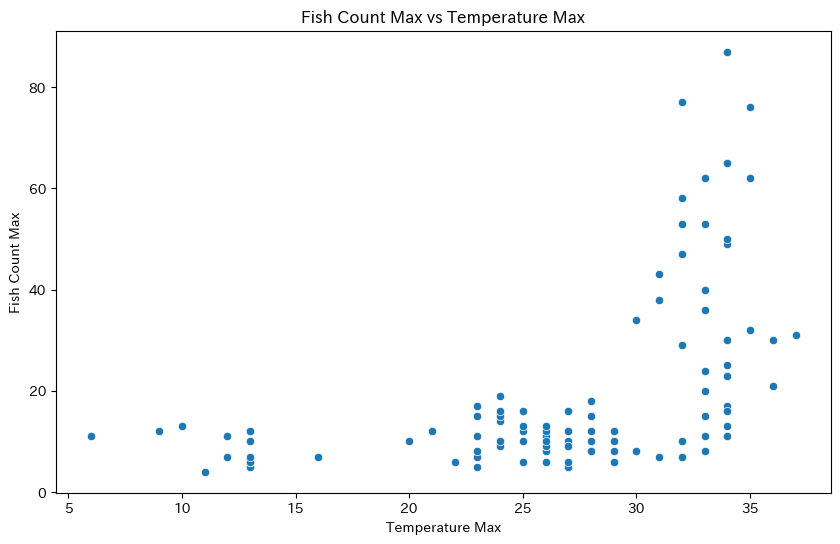

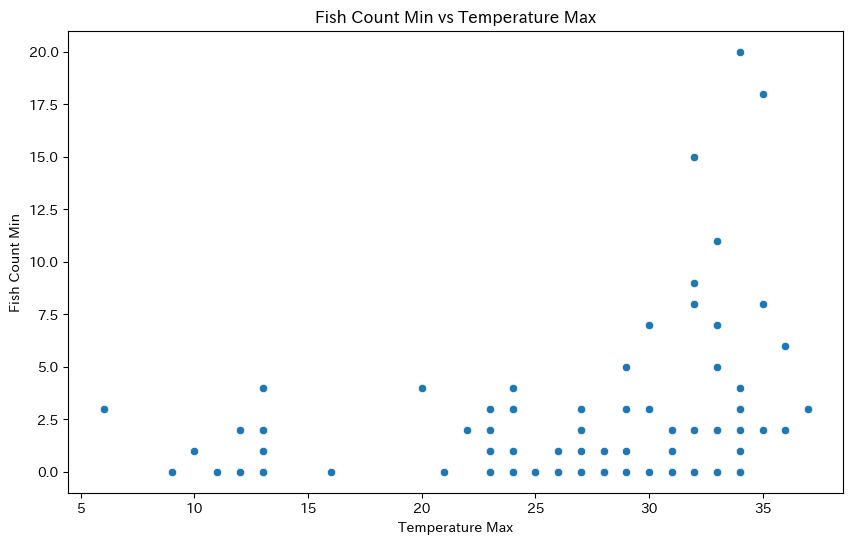

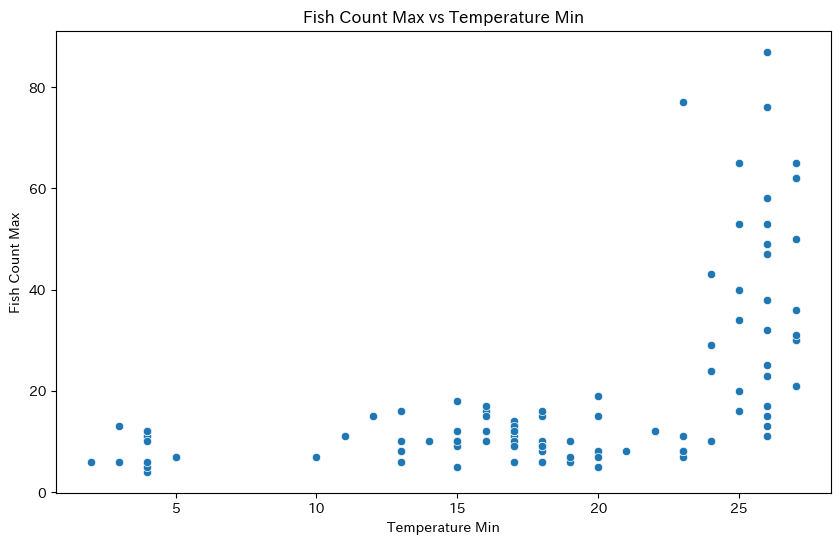

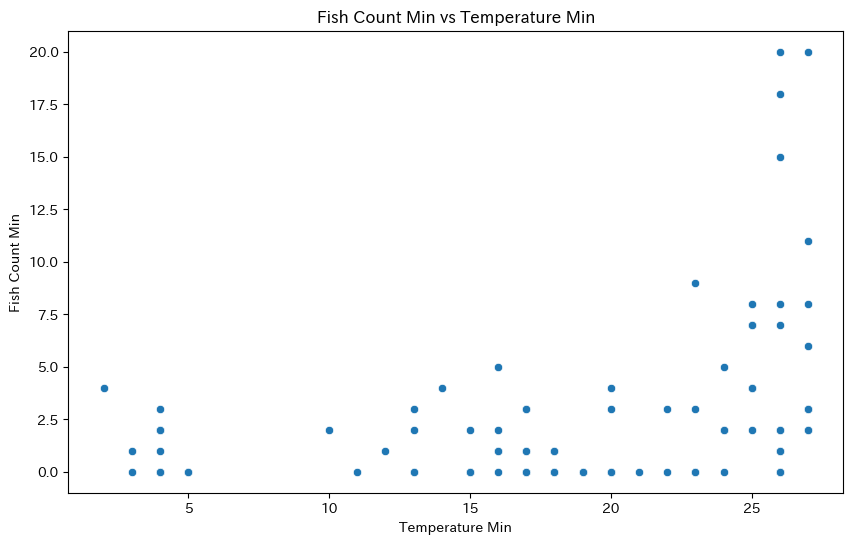

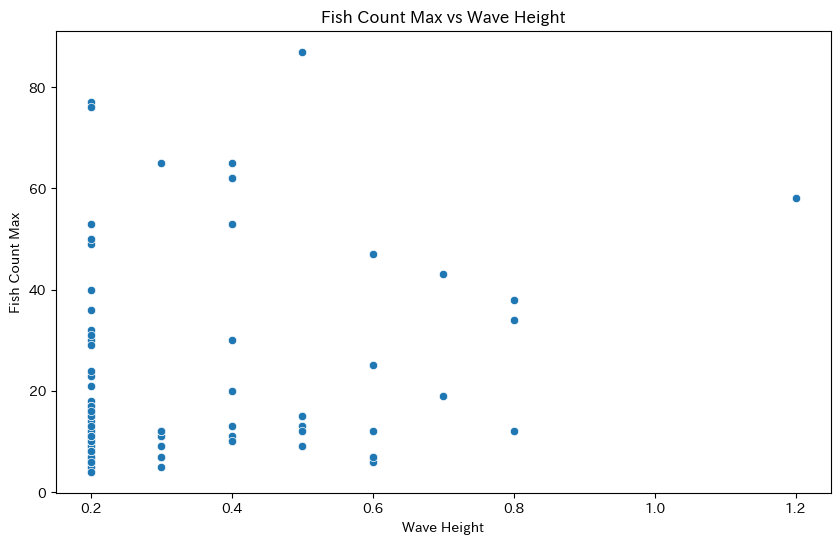

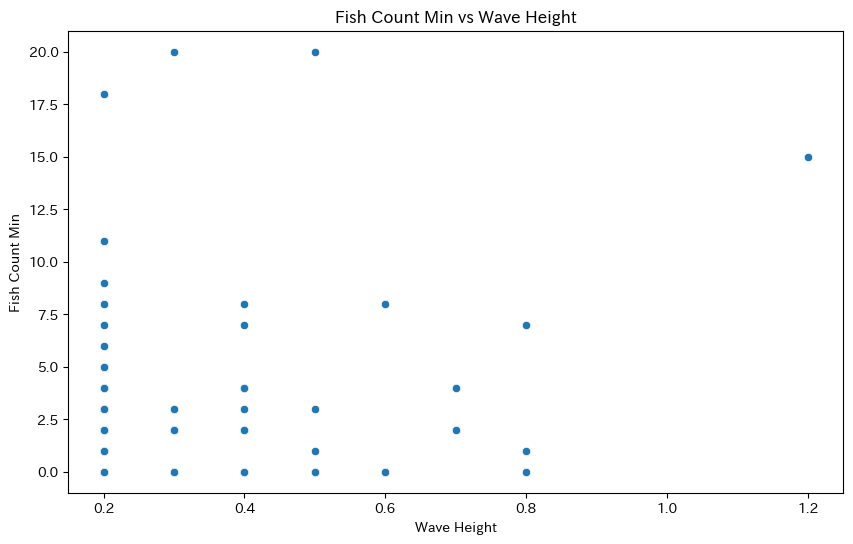

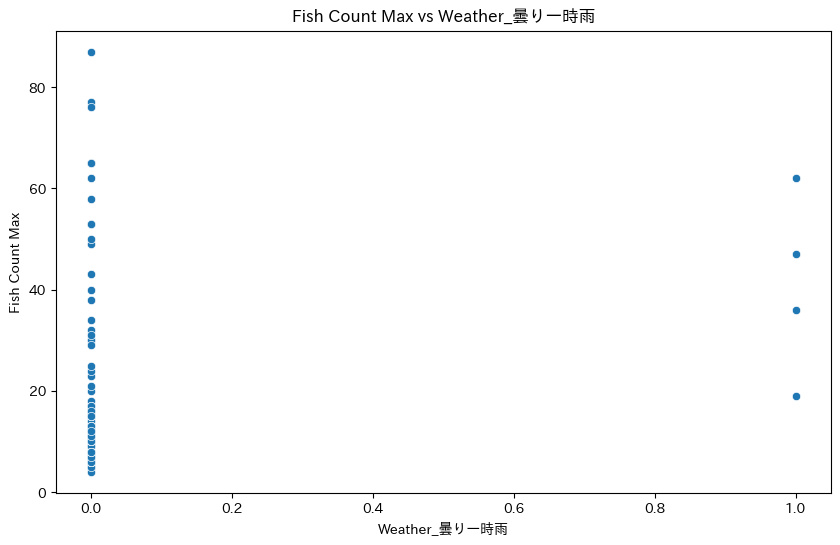

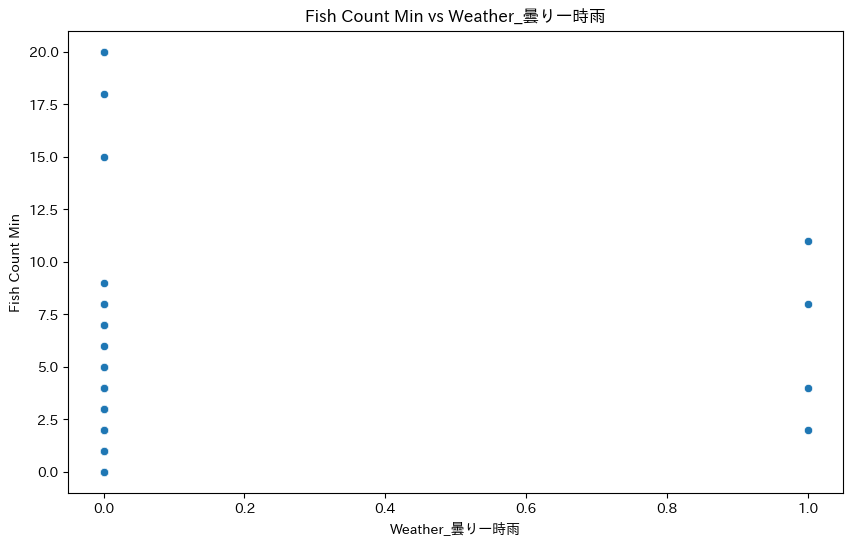

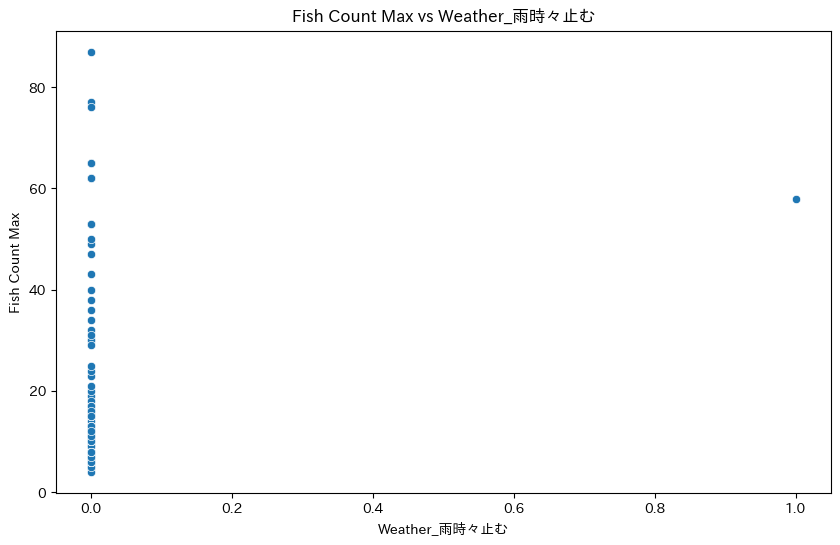

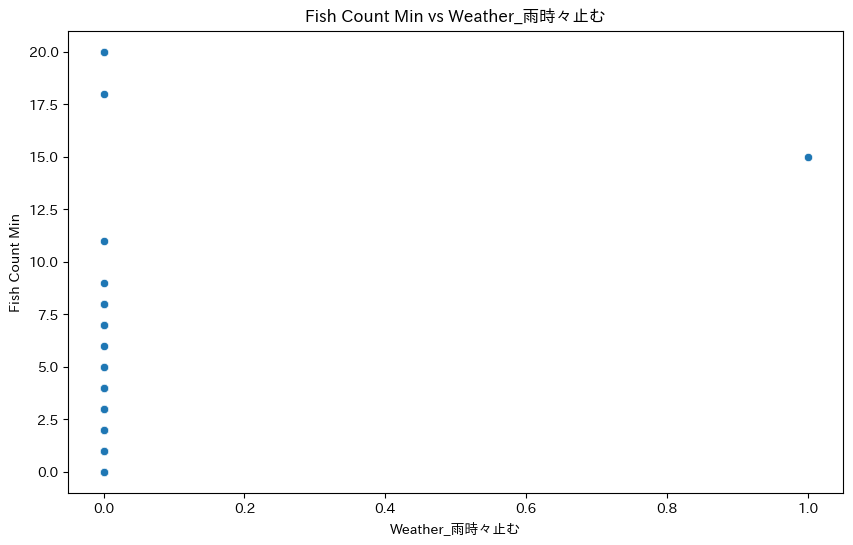

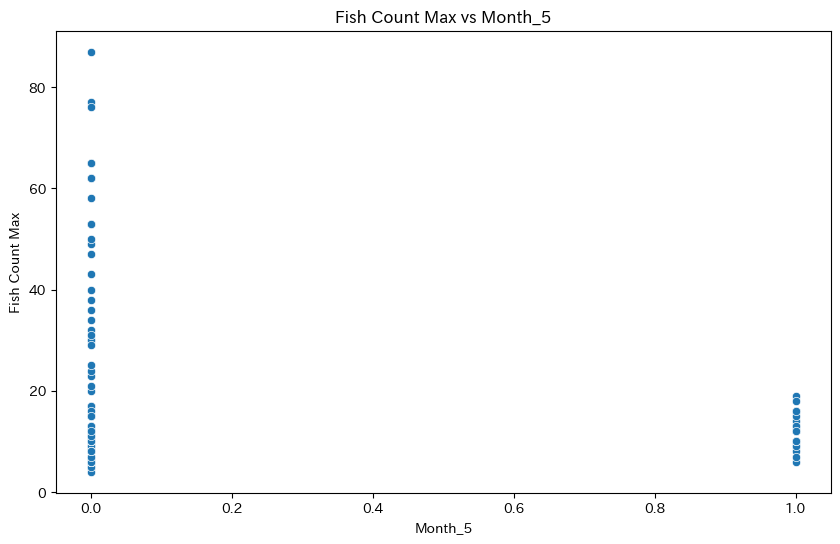

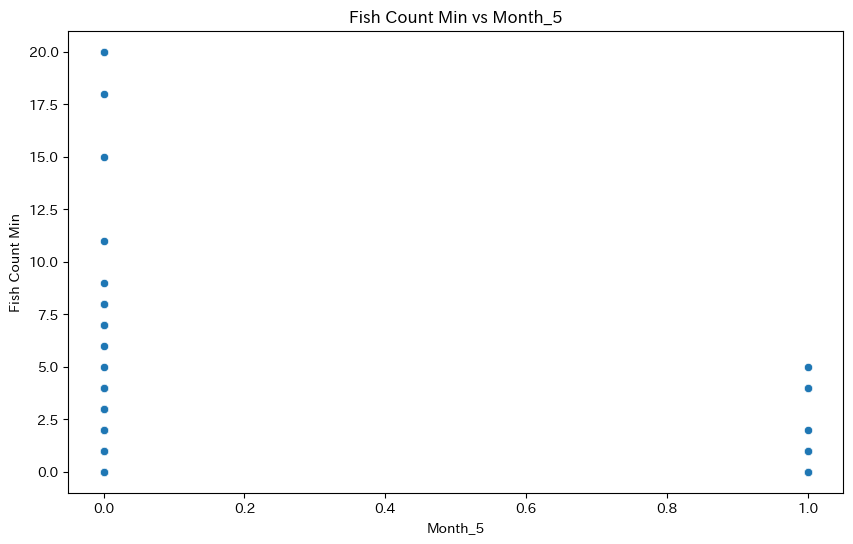

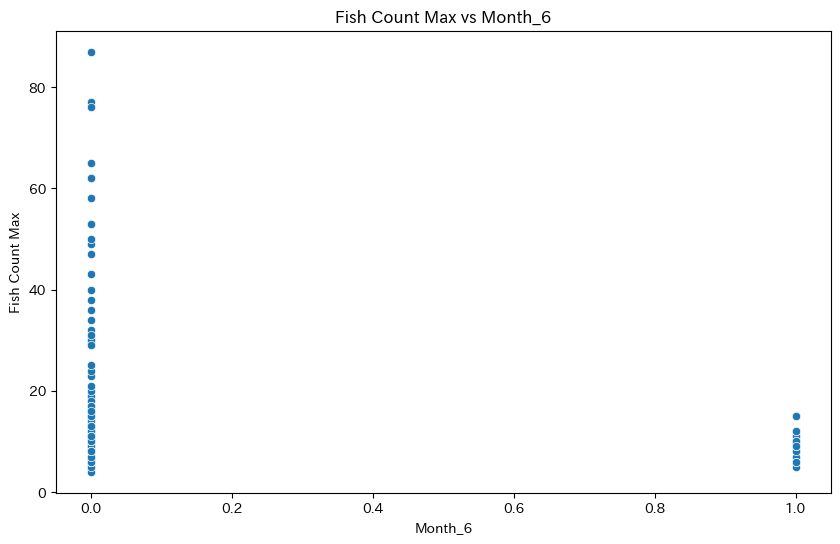

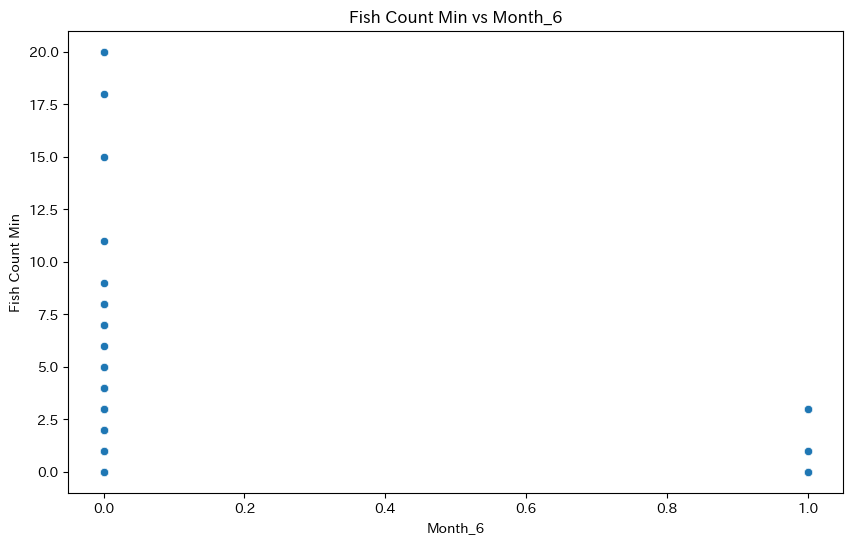

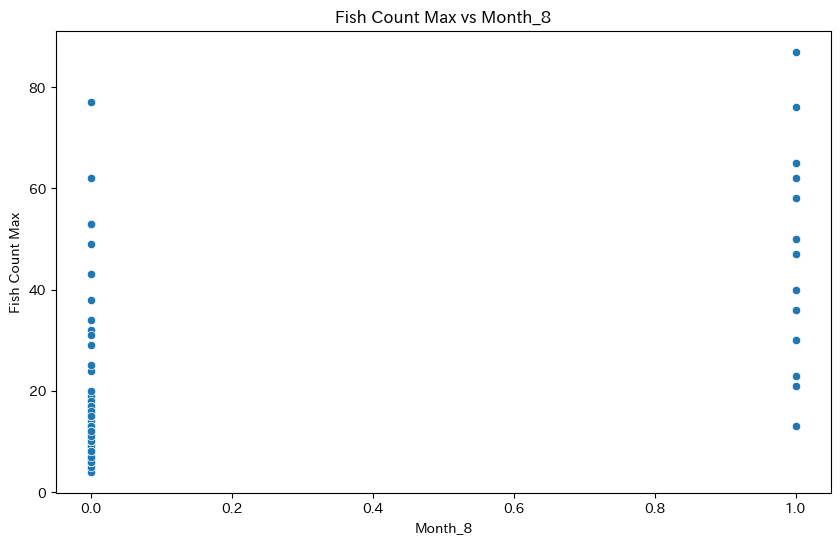

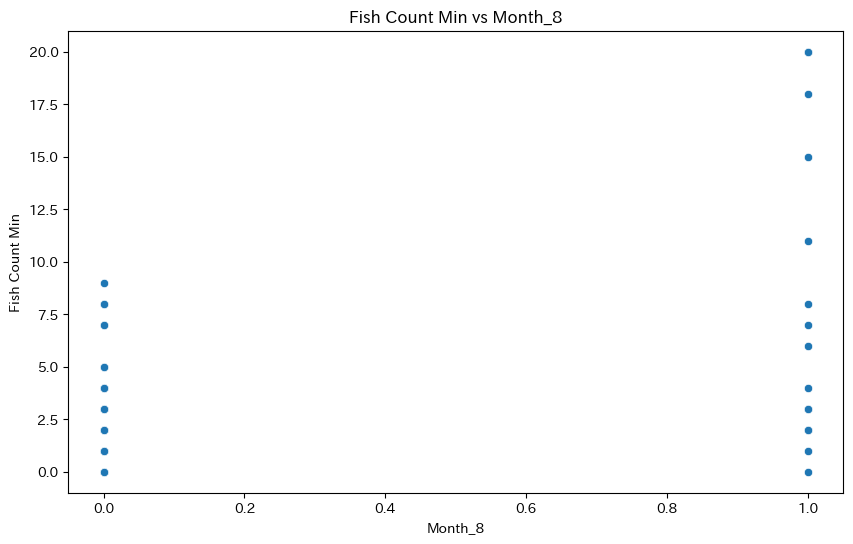

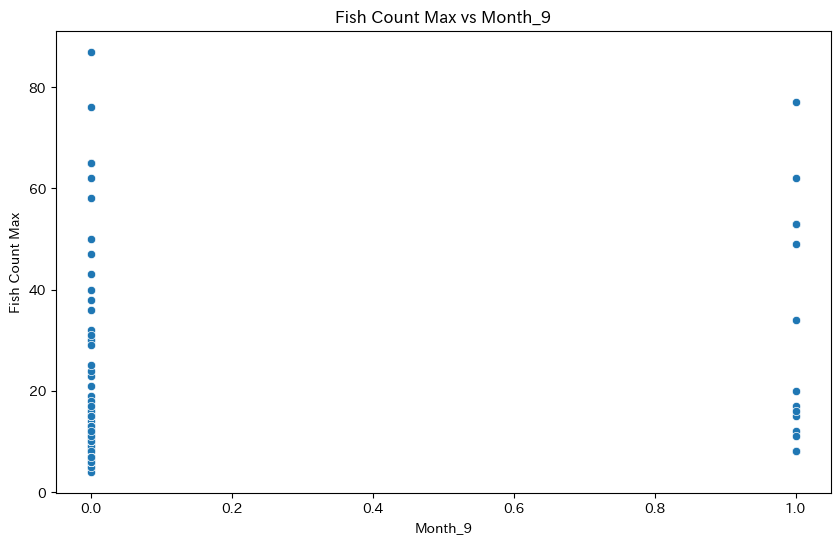

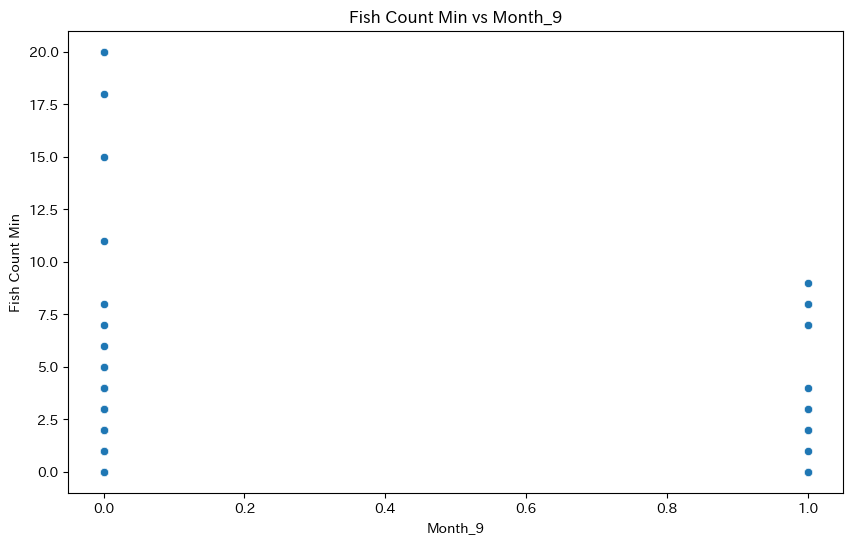

In [6]:
# 基本的な統計量の確認
# print(df_encoded.describe())

# 相関行列の作成
correlation_matrix = df_encoded.corr()

# 相関行列の表示
# print(correlation_matrix)

# 相関係数の絶対値が0.7以上の特徴量を選択
threshold = 0.2
high_corr_features = correlation_matrix.index[correlation_matrix['Fish Count Max'].abs() >= threshold].tolist()

# 'Fish Count Max'は除外
high_corr_features.remove('Fish Count Max')

# 相関ヒートマップの描画
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.loc[high_corr_features + ['Fish Count Max'], high_corr_features + ['Fish Count Max']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (High Correlation Features)')
plt.show()

# 釣果と他の特徴量の関係を散布図で確認
for feature in high_corr_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_encoded, x=feature, y='Fish Count Max')
    plt.title(f'Fish Count Max vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Fish Count Max')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_encoded, x=feature, y='Fish Count Min')
    plt.title(f'Fish Count Min vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Fish Count Min')
    plt.show()
